# GeoML with EuroSAT Notebook
In this notebook, we download and visualize EuroSAT data from both the spatial and non-spatial splits. We then train two ResNet50 image encoders on each dataset, one with randomly initialized weights and one with pre-initialized weights from SSL4EO-S12. We then evaluate each on the test and train data, and then customize the training.  

In [8]:
# data libraries
import os
from torch.utils.data import DataLoader
from torchgeo.datasets import EuroSAT, EuroSATSpatial, EuroSAT100
import random
import matplotlib.pyplot as plt

# ml libraries
import torch # for model training
from torch import nn # for neural network layers
from torch.utils.data import RandomSampler
from torch.utils.data import DataLoader
import torchvision.transforms as transforms # to resize input images
from torchgeo.models import resnet50 # import resnet50 model from torchvision
from torchgeo.models import ResNet50_Weights

## 1. Download and Visualize EuroSat Data

In this section, we use the torchgeo dataset/datamodules to download the EuroSat dataset (spatial and nonspatial split versions). We then plot a random sample of 6 images (with labels) from the training set and the test set for each dataset version. We also calculate the number of samples in each split for each version (spatial and nonspatial).

### EuroSAT 100

In [3]:
eurosat100_root = os.path.join("data", "eurosat100")
eurosat100_dataset_train = EuroSAT100(eurosat100_root, split="train", download=True)
eurosat100_dataset_test = EuroSAT100(eurosat100_root, split="test", download=True)

print(f'Dataset Classes: {eurosat100_dataset_train.classes}')
print(f'Number of images in train dataset: {len(eurosat100_dataset_train)}')
print(f'Number of images in test dataset: {len(eurosat100_dataset_test)}')

Dataset Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Number of images in train dataset: 60
Number of images in test dataset: 20


### EuroSAT

In [3]:
eurosat_root = os.path.join("data", "eurosat")
eurosat_dataset_train = EuroSAT(eurosat_root, split="train", download=True)
eurosat_dataset_test = EuroSAT(eurosat_root, split="test", download=True)

print(f'Dataset Classes: {eurosat_dataset_train.classes}')
print(f'Number of images in train dataset: {len(eurosat_dataset_train)}')
print(f'Number of images in test dataset: {len(eurosat_dataset_test)}')

100%|██████████| 2067725275/2067725275 [00:24<00:00, 84878165.64it/s]


100%|██████████| 313605/313605 [00:00<00:00, 12787691.21it/s]


100%|██████████| 104659/104659 [00:00<00:00, 4067377.00it/s]


100%|██████████| 104163/104163 [00:00<00:00, 5735739.63it/s]


Dataset Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Number of images in train dataset: 16200
Number of images in test dataset: 5400


### EuroSAT Spatial

In [4]:
eurosat_spatial_root = os.path.join("data", "eurosatSpatial")
eurosat_spatial_dataset_train = EuroSATSpatial(eurosat_spatial_root, split="train", download=True)
eurosat_spatial_dataset_test = EuroSATSpatial(eurosat_spatial_root, split="test", download=True)

print(f'Dataset Classes: {eurosat_spatial_dataset_train.classes}')
print(f'Number of images in train dataset: {len(eurosat_spatial_dataset_train)}')
print(f'Number of images in test dataset: {len(eurosat_spatial_dataset_test)}')

100%|██████████| 2067725275/2067725275 [00:17<00:00, 115761874.76it/s]


100%|██████████| 316710/316710 [00:00<00:00, 2815153.46it/s]


100%|██████████| 99786/99786 [00:00<00:00, 26501159.94it/s]


100%|██████████| 105934/105934 [00:00<00:00, 1216963.34it/s]


Dataset Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Number of images in train dataset: 16200
Number of images in test dataset: 5400


### # of Images in Each Dataset Split
Split    | EuroSAT100   | EuroSAT   | EuroSAT Spatial   |
---------|-----------   |---------  |---------          |
Train    |  60          |   16200   |   16200           |
Validate |  20          |   5400    |   5400            |
Test     |  20          |   5400    |   5400            |

### Visualize Images and Labels from Each Dataset

In [6]:
# set seed for reproducibility
random.seed(44)

eurosat_datasets = {
    "eurosat_train": eurosat_dataset_train,
    "eurosat_test": eurosat_dataset_test,
    "eurosat_spatial_train": eurosat_spatial_dataset_train,
    "eurosat_spatial_test": eurosat_spatial_dataset_test
}
figures_base_path = os.path.join("figures", "eurosat100")


# sample 6 random images, plot, and export the figures
for name, dataset in eurosat_datasets.items():
    n = 0
    for i in random.sample(range(len(dataset)), 6):
        fig = dataset.plot(
            sample=dataset.__getitem__(i),
            show_titles=True
        )
        # export fig to png
        path = os.path.join("figures", "eurosat", f"{name}_{n}.png")
        fig.savefig(path)
        plt.close(fig)
        n += 1

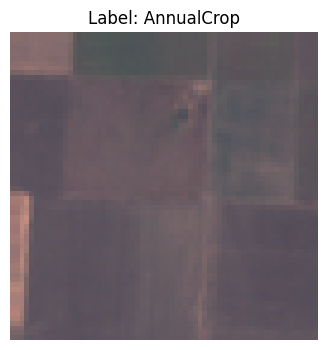

In [7]:
# visualize just one image
fig = eurosat_dataset_train.plot(
    sample=eurosat_dataset_train.__getitem__(0),
    show_titles=True
)

## 2. Train & Evaluate a Model on the EuroSAT Data 

In this section, we train two ResNet 50 models on the nonspatial EuroSat dataset: one with randomly initialized weights, and one with pre-initialized weights from the SSL4EO-S12 project (use the pretrained weights available in torchgeo). We report the performance of these models on the train and test sets in a table. In addition to the table, we report (i) how we implemented the training and evaluation procedure, what hyperparameters we use to train the model, and how we choose those hyperparameters (e.g. if we perform a cross-validation search for hyperparameters, we explain how you conducted that search), (ii) what pretrained weights we choose to use, and a short description of the process used to generate those weights, (iii) a short paragraph describing the results in your table in words.

The flow of this section is as follows:
1. Configure the GPU
1. Define the Train and Test Loos
1. Define a ResNet model with random weights, customize the model for EuroSat data
1. Define a data sampler and loader
1. Load and transform the data
1. Train & evaluate the model
1. Repeat with a pre-trained ResNet50
1. Report results

#### Configure GPU

In [2]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


#### Define the Train & Test Loops

In [3]:
# train loop
# from the pytorch tutorial
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, sample in enumerate(dataloader):
        X, y = sample['image'], sample['label']
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # print intermediate results every n batches
        n = 20
        if batch % n == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [4]:
# test loop
# from the pytorch tutorial
def test(dataloader, model, loss_fn, val=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for sample in dataloader:
            X, y = sample['image'], sample['label']
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    prefix = "Validation" if val else "Test"
    print(f"{prefix} Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

#### Define the Model

In [16]:
# import torchvision
model = resnet50(weights=None).to(device)


In [17]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [18]:
# modify the ResNet model to have 10 output classes
model.fc = nn.Linear(2048, 10).to(device)

# modify the model to expect 13 channels instead of 3
model.conv1 = nn.Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False).to(device)

In [19]:
learning_rate = 1e-3

# define training parameters
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#### Define the Dataloaders

In [20]:
# Custom transform function to handle the dictionary structure of torchgeo dataset
class CustomTransform:
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, sample):
        sample['image'] = self.transform(sample['image'])
        return sample
    
# Define transformations for the dataset to get it from 64x64 to 224x224
transform = transforms.Resize((224, 224))  # Resizes the images to 224x224

custom_transform = CustomTransform(transform)

#### Load the Data

In [28]:
batch_size = 64

# reload data with the new transform
root = os.path.join("data", "eurosat")
dataset_train = EuroSAT(root, split="train", download=True, transforms=custom_transform)
dataset_val = EuroSAT(root, split="val", download=True, transforms=custom_transform)
dataset_test = EuroSAT(root, split="test", download=True, transforms=custom_transform)

# define a sampler for the EuroSAT dataset
# it's a non-spatial dataset, so we can use a regular sampler from pytorch
sampler_train = RandomSampler(dataset_train, replacement=False) # start with a small batch
sampler_val = RandomSampler(dataset_val, replacement=False) # start with a small batch
sampler_test = RandomSampler(dataset_test, replacement=False) # start with a small batch

# define a dataloader to iterate over the dataset
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, sampler=sampler_train)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, sampler=sampler_val)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, sampler=sampler_test)

#### Train & Test the Model

In [29]:
epochs = 10

# baseline before training
print(f"Baseline Before Training\n-------------------------------")
test(dataloader_val, model, loss_fn)

# run train / test loop
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(dataloader_train, model, loss_fn, optimizer)
    test(dataloader_val, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.790203  [   64/16200]
loss: 2.353432  [ 1344/16200]
loss: 2.208539  [ 2624/16200]
loss: 2.197552  [ 3904/16200]
loss: 2.241841  [ 5184/16200]
loss: 2.145606  [ 6464/16200]
loss: 2.091316  [ 7744/16200]
loss: 1.980653  [ 9024/16200]
loss: 2.001280  [10304/16200]
loss: 1.937289  [11584/16200]
loss: 2.020346  [12864/16200]
loss: 1.924643  [14144/16200]
loss: 1.894397  [15424/16200]
Test Error: 
 Accuracy: 28.1%, Avg loss: 2.449632 

Epoch 2
-------------------------------
loss: 1.932123  [   64/16200]
loss: 1.943989  [ 1344/16200]
loss: 1.792065  [ 2624/16200]
loss: 1.857733  [ 3904/16200]
loss: 1.807787  [ 5184/16200]
loss: 1.723712  [ 6464/16200]
loss: 2.006612  [ 7744/16200]
loss: 1.615973  [ 9024/16200]
loss: 1.617400  [10304/16200]
loss: 1.547189  [11584/16200]
loss: 1.550488  [12864/16200]
loss: 1.702696  [14144/16200]
loss: 1.819835  [15424/16200]
Test Error: 
 Accuracy: 35.5%, Avg loss: 1.899144 

Epoch 3
----------------------------

#### To Do's
1. Figure out how to save down the model parameters after training
1. Figure out how to implement early stopping based on validation loss
1. Consider running the model for 10-50 epochs
1. Figure out how to plot train and val loss over time for given model runs
1. Experiment with the batch size and learning rate
1. Add a dynamic learning rate scheduler

## 3. Train & Evaluate a Model on the EuroSAT Spatial Data

#### Redefine the Model

In [22]:
model = resnet50(weights=ResNet50_Weights.SENTINEL2_ALL_MOCO).to(device) # note the model with these weights is 90.1MB

In [23]:
print(model)

ResNet(
  (conv1): Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [24]:
# modify the ResNet model to have 10 output classes
model.fc = nn.Linear(2048, 10).to(device)

#### Reload the New Data

In [29]:
batch_size = 64

# reload data with the new transform
root = os.path.join("data", "eurosatSpatial")
dataset_train = EuroSATSpatial(root, split="train", download=True, transforms=custom_transform)
dataset_val = EuroSATSpatial(root, split="val", download=True, transforms=custom_transform)
dataset_test = EuroSATSpatial(root, split="test", download=True, transforms=custom_transform)

# define a sampler for the EuroSATSpatial dataset
# it's a non-spatial dataset, so we can use a regular sampler from pytorch
sampler_train = RandomSampler(dataset_train, replacement=False) # start with a small batch
sampler_val = RandomSampler(dataset_val, replacement=False) # start with a small batch
sampler_test = RandomSampler(dataset_test, replacement=False) # start with a small batch

# define a dataloader to iterate over the dataset
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, sampler=sampler_train)
dataloader_val = DataLoader(dataset_val, batch_size=batch_size, sampler=sampler_val)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, sampler=sampler_test)

#### Train & Test the Model

In [32]:
epochs = 5

# baseline before training
print(f"Baseline Before Training\n-------------------------------")
test(dataloader_test, model, loss_fn, val=False)
test(dataloader_val, model, loss_fn, val=True)

# run train / val loop
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(dataloader_train, model, loss_fn, optimizer)
    test(dataloader_val, model, loss_fn)

# test result with test data
print("Test Results\n-------------------------------")
test(dataloader_test, model, loss_fn)

print("Done!")

Baseline Before Training
-------------------------------


Test Error: 
 Accuracy: 78.1%, Avg loss: 2.128347 

Epoch 1
-------------------------------
loss: 2.183523  [   64/16200]
loss: 2.191706  [ 1344/16200]
loss: 2.191686  [ 2624/16200]
loss: 2.174101  [ 3904/16200]
loss: 2.169603  [ 5184/16200]
loss: 2.185689  [ 6464/16200]
loss: 2.183465  [ 7744/16200]
loss: 2.160785  [ 9024/16200]
loss: 2.164845  [10304/16200]
loss: 2.154418  [11584/16200]
loss: 2.159639  [12864/16200]
loss: 2.147842  [14144/16200]
loss: 2.167273  [15424/16200]
Test Error: 
 Accuracy: 79.4%, Avg loss: 2.043599 

Epoch 2
-------------------------------
loss: 2.145595  [   64/16200]
loss: 2.134872  [ 1344/16200]
loss: 2.147903  [ 2624/16200]
loss: 2.156779  [ 3904/16200]
loss: 2.130998  [ 5184/16200]
loss: 2.131555  [ 6464/16200]
loss: 2.136301  [ 7744/16200]
loss: 2.120452  [ 9024/16200]
loss: 2.129006  [10304/16200]
loss: 2.112543  [11584/16200]
loss: 2.096720  [12864/16200]
loss: 2.107255  [14144/16200]
loss: 2.087829  [15424/16200]
Test Error: 
 Accuracy: 80.0%, Avg l

#### Save the Current Model

In [33]:
# export the current model weights
experiment_name = "eurosatspatial_resnet50_pretrained_epochs10.pth"
model_weights_path = os.path.join("models", "eurosat", experiment_name)
torch.save(model.state_dict(), model_weights_path)